In [1]:
import numpy as np
import pandas as pd
import scipy 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Grab and process the raw data.
amazon = open('amazon_cells_labelled.txt', mode = 'r+')
text = amazon.readlines()
print ('This file is {} lines long.'.format(len(text)))


This file is 1000 lines long.


In [3]:
df = pd.read_table('amazon_cells_labelled.txt', names=('Message', 'Sentiment'))

# Import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()

df = pd.read_table('amazon_cells_labelled.txt', names=('Message', 'Sentiment'))

# list of keywords we are interested in
keywords = ['good', 'excellent', 'great', 'impressed', 'quality', 'recommend', 'loved', 'best', 'ideal', 'well', 'nice', 'right', 'has', 'neat', 'love', 'reasonable', 'works', 'happy', 'cool', 'comfortable', 'beautiful', 'seamlessly', 'fast', 'simple', 'comfortably', 'pleased', 'brilliant', 'nicely']

# find the root of each word
stem_keywords = [ps.stem(key) for key in keywords]    

#  Turn the spam column into a boolean so we can easily do some statistics to prepare for modeling
df['Sentiment'] = (df['Sentiment'] == 1)

# tokenize and stem each word in each message
df['message_tokens'] = df['Message'].apply(lambda row: [ps.stem(w) for w in word_tokenize(row)])

# for each row find if the stem of the keyword exist in the message
for key in stem_keywords:
    df[key] = df.apply(lambda row: key in row.message_tokens, axis=1)

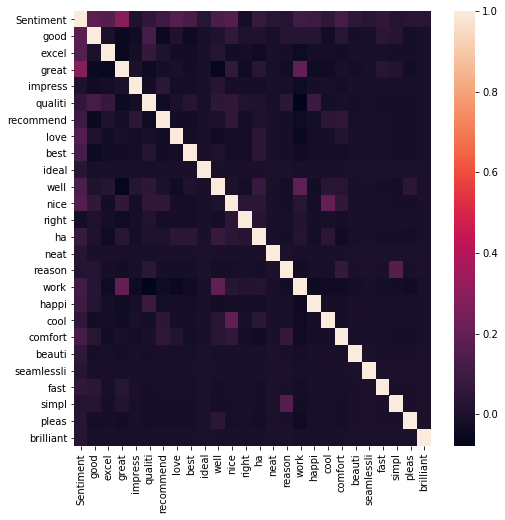

In [4]:
# Create a heatmap to check for independence between variables
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df.corr())

In [5]:
# Define target and training variables
data = df[stem_keywords]
target = df['Sentiment']

In [6]:
# Apply Naive Bayes model to training set and print accuracy
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()

bnb.fit(data, target)

y_pred = bnb.predict(data)

print('Number of mislabeled points out of a total {} points : {}'.format(data.shape[0], (target != y_pred).sum()))

Number of mislabeled points out of a total 1000 points : 239


My features are a compilation of kewyords that are explicitely identifiable with positive sentiments. The more keywords that are inlcuded, the more accurate the model predicts the data, but at a decreasing rate (like a square-root function).

In [7]:
# create confusion matrix to visualize errors
# negatives, positives

from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[460,  40],
       [199, 301]])

In [8]:
# Create hold out groups for crosstabing to check for over-fitting

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=30)
print('With 30% holdout: ' + str(bnb.fit(x_train, y_train).score(x_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 30% holdout: 0.72
Testing on Sample: 0.761


In [9]:
# Cross Validation just to make sure theres no overfitting

from sklearn.model_selection import cross_val_score

cross_val_score(bnb, data, target, cv=5)

array([0.8  , 0.79 , 0.74 , 0.7  , 0.735])